In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
from torch.nn import functional as F

import os

import numpy as np 

import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
labels = {
    0: 'Unlabeled',
    1: 'Trees',
}

In [5]:
images = []
segmentation_masks = []

for img_name in os.listdir(r'C:\Users\ffedo\Desktop\data science\data\2_rucode\segm_train\train\images'):
    images.append('C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/images/' + img_name)

for img_name in os.listdir(r'C:\Users\ffedo\Desktop\data science\data\2_rucode\segm_train\train\gt'):
    segmentation_masks.append('C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/gt/' + img_name)

In [6]:
images[:5], segmentation_masks[:5]

(['C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/images/1.tif',
  'C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/images/10.tif',
  'C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/images/100.tif',
  'C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/images/1000.tif',
  'C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/images/1001.tif'],
 ['C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/gt/1.tif',
  'C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/gt/10.tif',
  'C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/gt/100.tif',
  'C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/gt/1000.tif',
  'C:/Users/ffedo/Desktop/data science/data/2_rucode/segm_train/train/gt/1001.tif'])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

        # self.images_transforms = transforms.Compose([
        #     transforms.Resize((256, 256)), # размер каждой картинки будет приведен к 256*256
        #     transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        #     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # значения пикселей картинки нормализуются
        # ])

        # self.masks_transforms = transforms.Compose([
        #     transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # размер каждой картинки будет приведен к 256*256
        #     transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        # ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = ToTensor()(Image.open(self.images[ind]))

        # mask = ToTensor()(Image.open(self.masks[ind])).reshape(256,256)

        mask = Image.open(self.masks[ind])
        mask = np.array(mask, dtype=np.bool_)
        mask = np.array(mask, dtype=np.float_)
        mask = ToTensor()(mask).reshape(256,256)
         
        #img = self.images_transforms(image)
        #mask = self.masks_transforms(mask)
        
        return img, mask

In [8]:
dataset = CustomDataset(images, segmentation_masks)

In [9]:
dataset[0][1].shape

torch.Size([256, 256])

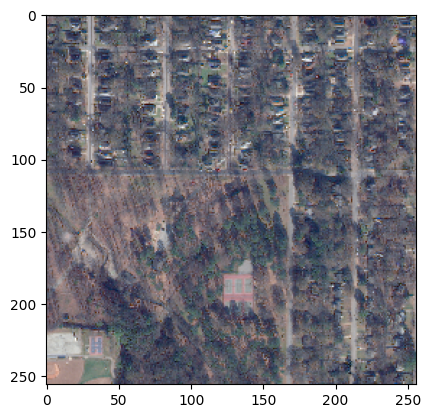

In [10]:
plt.imshow(dataset[0][0].permute(1,2,0))

In [11]:
print(dataset[0][1].shape)
dataset[0][1]

torch.Size([256, 256])


tensor([[1., 1., 1.,  ..., 1., 0., 0.],
        [0., 1., 1.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

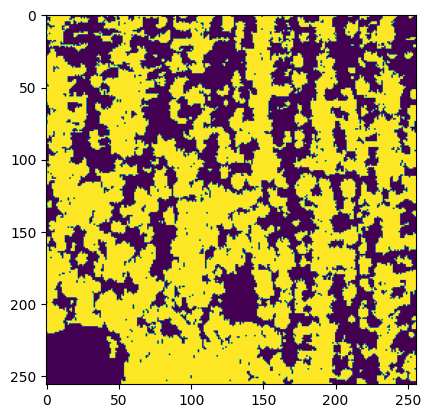

In [12]:
plt.imshow(dataset[0][1])

In [13]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64)
train_loader

In [18]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d((2, 2))  # 256 -> 128
        self.enc_bn0 = nn.BatchNorm2d(num_features=8)
        self.enc_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
        self.enc_bn1 = nn.BatchNorm2d(num_features=8)
        self.enc_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
        self.enc_bn2 = nn.BatchNorm2d(num_features=16)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_bn0 = nn.BatchNorm2d(num_features=32)
        # слой ConvTranspose2d c такими параметрами не меняет размер
        # карт активаций. 
        self.dec_conv0 = nn.ConvTranspose2d(32, 8, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_bn1 = nn.BatchNorm2d(num_features=16)
        self.dec_conv1 = nn.ConvTranspose2d(16, 8, 3, padding=1) 
        self.upsample2 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_bn2 = nn.BatchNorm2d(num_features=16)
        self.dec_conv2 = nn.ConvTranspose2d(16, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_bn0(self.pool0(F.relu(self.enc_conv0(x))))
        e1 = self.enc_bn1(self.pool1(F.relu(self.enc_conv1(e0))))
        e2 = self.enc_bn2(self.pool2(F.relu(self.enc_conv2(e1))))

        # bottleneck
        b = self.bottleneck_conv(e2)

        # decoder
        d0 = self.dec_conv0(self.dec_bn0(F.relu(self.upsample0(torch.cat([b, e2], 1)))))
        d1 = self.dec_conv1(self.dec_bn1(F.relu(self.upsample1(torch.cat([d0, e1], 1)))))
        d2 = self.dec_conv2(self.dec_bn2(F.relu(self.upsample2(torch.cat([d1, e0], 1)))))
        
        return d2.reshape(64,256,256)

In [19]:
class Seg(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            )
    def forward(self, x):
        # encoder
        e0, indices_e0 = self.pool0(self.enc_conv0(x))
        e1, indices_e1 = self.pool1(self.enc_conv1(e0))
        e2, indices_e2 = self.pool2(self.enc_conv2(e1))
        e3, indices_e3 = self.pool3(self.enc_conv3(e2))
        # bottleneck
        b = self.bottleneck_conv(e3)
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, indices_e3))
        d1 = self.dec_conv1(self.upsample1(d0, indices_e2))
        d2 = self.dec_conv2(self.upsample2(d1, indices_e1))
        d3 = self.dec_conv3(self.upsample3(d2, indices_e0))  # no activation
        return d3#.reshape(64,256,256)
# BCE Loss
# def bce_loss(y_real, y_pred):
#     y_pred = torch.sigmoid(y_pred)
#     return (y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))).mean()


In [28]:
def train(model, opt, loss_fn, epochs, data_train):
    
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for i, (X_batch, Y_batch) in enumerate(tqdm(data_train)):
            # переносим батч на GPU
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            Y_pred = model(X_batch)
            print(Y_pred)
            # Y_pred = torch.flatten(Y_pred, start_dim=2, end_dim=-1)
            # Y_batch = torch.flatten(Y_batch, start_dim=1, end_dim=-1)
            loss = loss_fn(Y_pred, Y_batch.float())
            #loss = bce_loss(Y_pred, Y_batch.long())
            loss.backward()  
            opt.step()  
            opt.zero_grad()

            
            avg_loss += loss / len(train_loader)

            # после каждой эпохи будем визуализировать 
            # сегментацию на шести картинках из data_val

            if i%10 == 0:

                # выводим средний лосс на последних пяти обучающих итерациях
                print('avg train loss: %f' % avg_loss)

            avg_loss = 0
    

In [24]:
device = 'cpu'

In [29]:
lst=[]
model = SegNet().to(device)
#loss = bce_loss()
loss = nn.BCELoss()
# loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
train(model, opt, loss, 1, train_loader)

* Epoch 1/1


  0%|          | 0/45 [00:00<?, ?it/s]

torch.Size([64, 256, 256])


RuntimeError: all elements of input should be between 0 and 1

In [70]:
class testDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = ToTensor()(Image.open(self.images[ind]))
        
        return img, self.images[ind][75:]

In [71]:
timages=[]
for img_name in os.listdir(r'C:\Users\ffedo\OneDrive\Документы\data\segm_public_test\public_test\images'):
    timages.append('C:/Users/ffedo/OneDrive/Документы/data/segm_public_test/public_test/images/' + img_name)
timages[:5]

['C:/Users/ffedo/OneDrive/Документы/data/segm_public_test/public_test/images/t1_1.tif',
 'C:/Users/ffedo/OneDrive/Документы/data/segm_public_test/public_test/images/t1_10.tif',
 'C:/Users/ffedo/OneDrive/Документы/data/segm_public_test/public_test/images/t1_100.tif',
 'C:/Users/ffedo/OneDrive/Документы/data/segm_public_test/public_test/images/t1_101.tif',
 'C:/Users/ffedo/OneDrive/Документы/data/segm_public_test/public_test/images/t1_102.tif']

In [72]:
tdataset = testDataset(timages)

In [73]:
tdataset[0]

(tensor([[[0.4157, 0.4667, 0.2902,  ..., 0.3412, 0.4275, 0.6549],
          [0.4549, 0.5686, 0.6706,  ..., 0.4431, 0.4863, 0.6667],
          [0.6431, 0.6980, 0.6471,  ..., 0.5333, 0.5490, 0.6824],
          ...,
          [0.4549, 0.4196, 0.4078,  ..., 0.3216, 0.2941, 0.3216],
          [0.4510, 0.4353, 0.3804,  ..., 0.3961, 0.3020, 0.3098],
          [0.4863, 0.4745, 0.3569,  ..., 0.3647, 0.3098, 0.3490]],
 
         [[0.3922, 0.4510, 0.2157,  ..., 0.5176, 0.4471, 0.6549],
          [0.4392, 0.5647, 0.6863,  ..., 0.5137, 0.4941, 0.6745],
          [0.6980, 0.7412, 0.6549,  ..., 0.5255, 0.5451, 0.6902],
          ...,
          [0.4118, 0.3804, 0.4157,  ..., 0.2627, 0.2706, 0.3255],
          [0.4275, 0.4431, 0.4118,  ..., 0.4118, 0.3333, 0.3569],
          [0.4588, 0.4588, 0.3255,  ..., 0.3451, 0.3333, 0.4039]],
 
         [[0.3843, 0.4667, 0.2471,  ..., 0.5216, 0.3373, 0.6196],
          [0.4039, 0.5098, 0.6941,  ..., 0.4196, 0.3882, 0.6353],
          [0.7412, 0.7608, 0.6235,  ...,

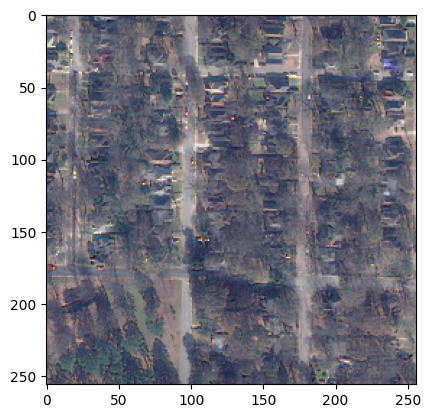

In [74]:
plt.imshow(tdataset[0][0].permute(1,2,0))

In [75]:
predloader = DataLoader(tdataset, batch_size=1)
predloader

In [76]:
model.eval()
lst_ts=[]
with torch.no_grad():
    for i, (X, name) in enumerate(tqdm(predloader)):
        X = X.to(device)
        
        Y_pred = model(X).reshape(256,256).detach().cpu().numpy() 
        
        #print(Y_hat.shape)
        lst_ts.append(Y_pred)

        cv2.imwrite('C:/Users/ffedo/peni/'+name[0], Y_pred)

  0%|          | 0/707 [00:00<?, ?it/s]

In [78]:
lst_ts[0].shape

(256, 256)

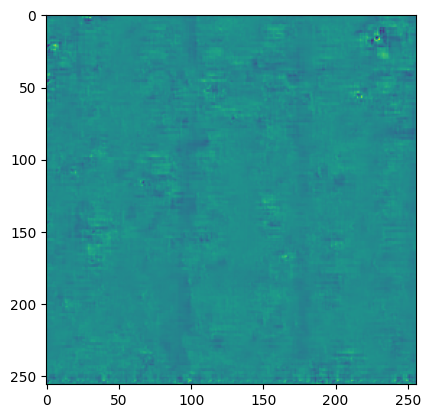

In [79]:
plt.imshow(lst_ts[0])

# создание NPY

In [80]:
# Указать здесь путь до test набора
path_to_dir = 'C:/Users/ffedo/peni'

In [81]:
# Получение списка всех файлов в директории
files = os.listdir(path_to_dir)
len(files)

707

In [99]:
def read_image_as_tensor(file_path):
    # Чтение изображения с помощью OpenCV
    image = Image.open(file_path)
    # Преобразование в тензор numpy
    tensor = np.array(image, dtype=np.bool_)
    return tensor

In [100]:
# Список для хранения тензоров
tensor_list = []

In [102]:
# Чтение и преобразование каждого изображения в тензор и добавление его в список
for filename in files:
    file_path = os.path.join(path_to_dir, filename)
    tensor = read_image_as_tensor(file_path)
    tensor_list.append(tensor)

In [104]:
# Преобразование списка тензоров в тензор numpy
tensor_array = np.array(tensor_list)

In [105]:
tensor_array

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [106]:
# Печать размерности полученного тензора. Проверьте, что количество количество снимков совпадает с количеством полученных тензоров маски
print("Размерность тензора:", tensor_array.shape)

Размерность тензора: (707, 256, 256)


In [107]:
output_file = "C:/Users/ffedo/solution.npy"
# Сохранение тензорного массива в файл .npy
np.save(output_file, tensor_array)